# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import scipy.sparse as sp
import pandas as pd
from sklearn.preprocessing import minmax_scale
import anndata
import scanpy as sc
import sctk as sk

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import plotnine as pln
from plotnine import ggplot, aes
import seaborn as sn

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

/home/ubuntu/miniconda/envs/scanpy-new/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load data

In [2]:
fetal_ad0 = sc.read('fetal_skin.processed_with_norm_X_counts_layer.maternal_removed.20211029.h5ad')

Only considering the two last: ['.20211029', '.h5ad'].
Only considering the two last: ['.20211029', '.h5ad'].


In [3]:
fetal_ad0

AnnData object with n_obs × n_vars = 186582 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc'
    uns: 'neighbors', 'neighbors_bk', 'pca'
    obsm: 'X_pca', 'X_umap', 'X_umap_bk'
    layers: 'counts'

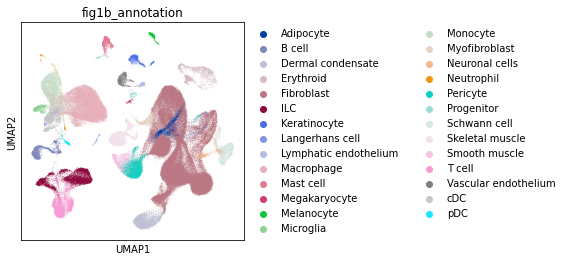

In [4]:
sk.set_figsize((4, 4))
sc.pl.embedding(fetal_ad0, basis='umap', color='fig1b_annotation')

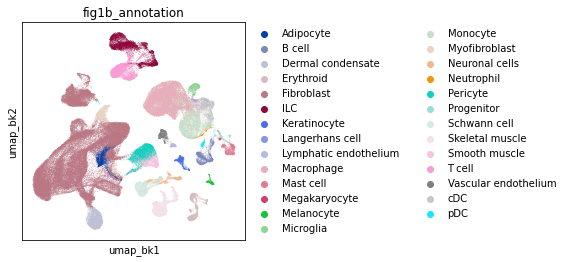

In [5]:
sk.set_figsize((4, 4))
sc.pl.embedding(fetal_ad0, basis='umap_bk', color='fig1b_annotation')

# Preprocess 

Make a copy without `obsm` and `uns`

In [6]:
fetal_ad1 = anndata.AnnData(
    X=fetal_ad0.X,
    var=fetal_ad0.var.copy(),
    obs=fetal_ad0.obs.copy()
)

Find highly variable genes with seurat_v3 method

In [7]:
fetal_ad1.raw = fetal_ad1
fetal_ad1.layers['counts'] = fetal_ad0.layers['counts']
sc.pp.highly_variable_genes(fetal_ad1, layer='counts', n_top_genes=2000, flavor='seurat_v3', subset=True, batch_key='donor')

Remove mito, ribo, cell cycle genes from HVG

In [8]:
fetal_ad2 = fetal_ad1[: ,~(fetal_ad1.var.mito | fetal_ad1.var.ribo | fetal_ad1.var.cc)].copy()

In [9]:
fetal_ad2

AnnData object with n_obs × n_vars = 186582 × 1775
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_cells', 'cc', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

PCA

In [10]:
sc.pp.scale(fetal_ad2, max_value=10)
sc.pp.pca(fetal_ad2, n_comps=30) 

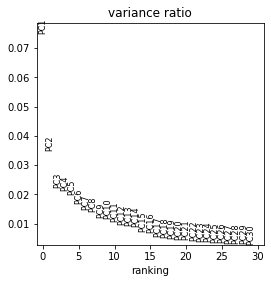

In [11]:
sc.pl.pca_variance_ratio(fetal_ad2)

Correct PCs by `harmony`

In [12]:
sk.run_harmony(fetal_ad2, batch='donor')

2021-10-30 22:43:28,424 - harmonypy - INFO - Iteration 1 of 20
2021-10-30 22:45:14,171 - harmonypy - INFO - Iteration 2 of 20
2021-10-30 22:47:03,997 - harmonypy - INFO - Iteration 3 of 20
2021-10-30 22:48:52,672 - harmonypy - INFO - Iteration 4 of 20
2021-10-30 22:50:43,529 - harmonypy - INFO - Iteration 5 of 20
2021-10-30 22:52:33,802 - harmonypy - INFO - Iteration 6 of 20
2021-10-30 22:54:24,997 - harmonypy - INFO - Iteration 7 of 20
2021-10-30 22:56:10,813 - harmonypy - INFO - Iteration 8 of 20
2021-10-30 22:57:50,416 - harmonypy - INFO - Iteration 9 of 20
2021-10-30 22:59:19,197 - harmonypy - INFO - Iteration 10 of 20
2021-10-30 23:00:52,698 - harmonypy - INFO - Converged after 10 iterations


In [13]:
sk.pp.neighbors(fetal_ad2, n_pcs=30, use_rep='X_pca_hm', key_added='neighbors_hm')

In [14]:
sc.tl.umap(fetal_ad2, neighbors_key='neighbors_hm') 

In [15]:
sk._obj_utils._rename_obsm_key(fetal_ad2, 'X_umap', 'X_umap_hm')

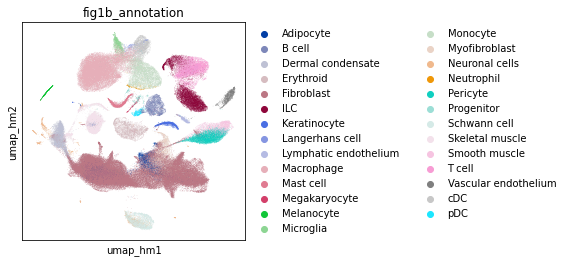

In [16]:
sc.pl.embedding(fetal_ad2, basis='umap_hm', color='fig1b_annotation')

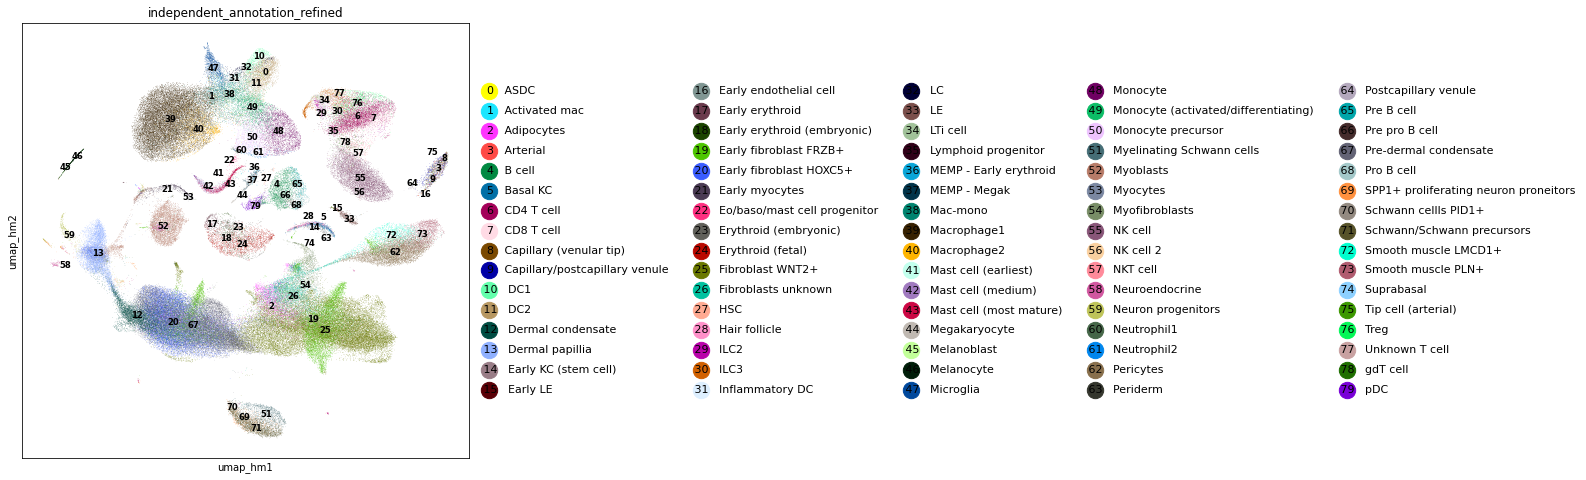

In [27]:
sk.plot_embedding(fetal_ad2, basis='umap_hm', groupby='independent_annotation_refined', figsize=(8,8), legend_fontsize=10);

Correct KNN by `bbknn`

In [17]:
sk.run_bbknn(fetal_ad2, batch='donor', use_rep='X_pca', key_added='bk', metric='euclidean')

In [18]:
sc.tl.umap(fetal_ad2, neighbors_key='neighbors_bk')

In [19]:
sk._obj_utils._rename_obsm_key(fetal_ad2, 'X_umap', 'X_umap_bk')

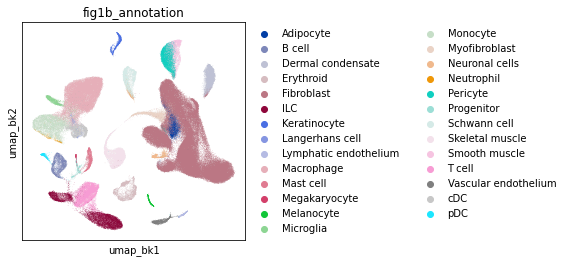

In [ ]:
sc.pl.embedding(fetal_ad2, basis='umap_bk', color='fig1b_annotation')

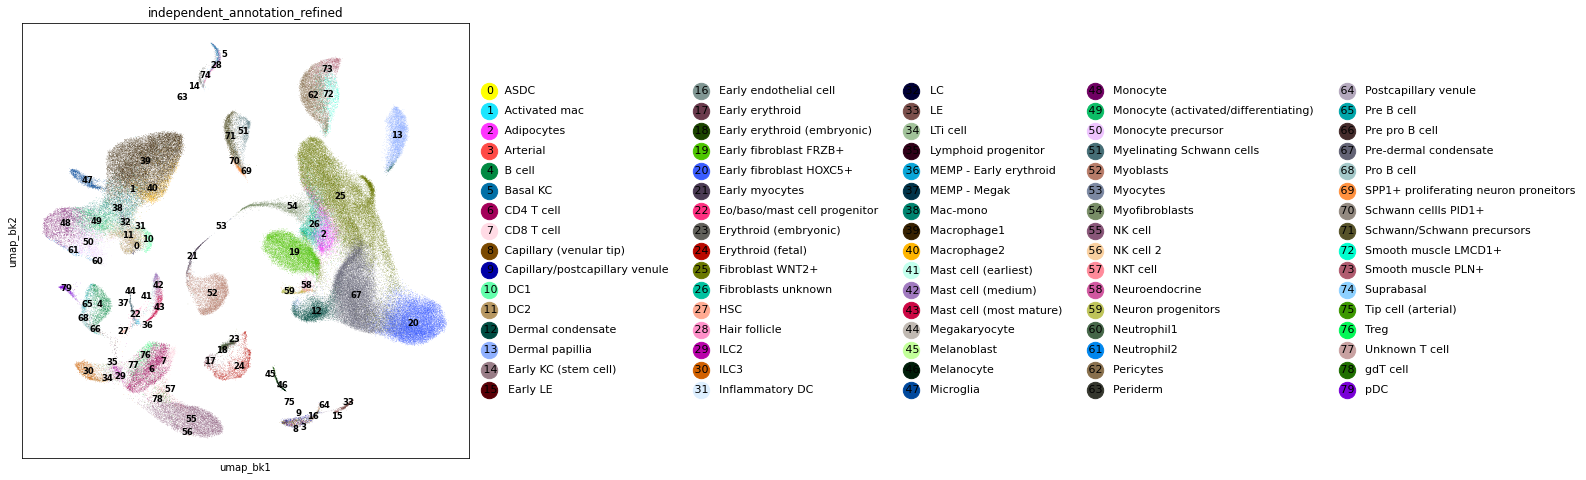

In [26]:
sk.plot_embedding(fetal_ad2, basis='umap_bk', groupby='independent_annotation_refined', figsize=(8,8), legend_fontsize=10);

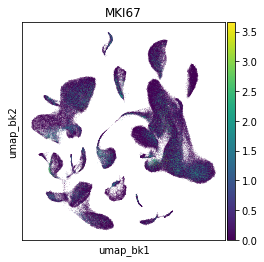

In [21]:
sc.pl.embedding(fetal_ad2, basis='umap_bk', color='MKI67')

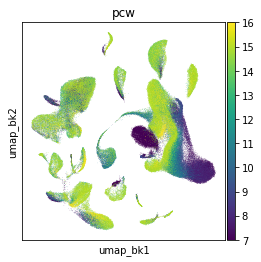

In [28]:
sk.set_figsize((4,4))
sc.pl.embedding(fetal_ad2, basis='umap_bk', color='pcw')

In [30]:
fetal_ad2.write('fetal_skin.reprocess_hm_bk.20211030.h5ad', compression='lzf')